In [30]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import ariel_load
import ariel_load_FGS
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib
from tqdm import tqdm
kgs.debugging_mode = 0
kgs.profiling=False
print('debug mode!')
kgs.n_workers = 4

debug mode!


In [31]:
train_data = kgs.load_all_train_data()
train_data = train_data

In [32]:
# importlib.reload(kgs)
# for d in train_data:
#     d.spectrum_cov = np.ones((283,283))
# kgs.mats_to_data(train_data, train_data, kgs.data_to_mats(train_data,train_data))
# kgs.score_metric(train_data, train_data)

In [80]:
importlib.reload(ariel_model)
todo = dict()

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
todo['New baseline'] = model

model = ariel_model.Fudger2(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
todo['New baseline fudger2'] = model

In [81]:

kgs.sanity_checks_active = True
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        
        print('!!! also loader')
        model_ref = kgs.dill_load(fname('New baseline'))[1]
        model._cached_planet_id = model_ref._cached_planet_id
        model._cached_result = model_ref._cached_result
        # model.bias_a = model_ref.bias_a
        # model.bias_b = model_ref.bias_b
        # model.sigma_fudge_FGS = model_ref.sigma_fudge[0]
        # model.sigma_fudge_AIRS_mean = model_ref.sigma_fudge[1]
        # model.sigma_fudge_AIRS_var = model_ref.sigma_fudge[1]
        
        # Precache data
        #for d in tqdm(train_data):
        #    copy.deepcopy(d).load_to_step(5,model.model.starter_model.loaders)
        
        
        
        #model.state=1
        model.train(train_data)
        #kgs.list_attrs(model)
        inferred_data = model.infer(train_data)
        print(k)
        print(kgs.score_metric(inferred_data, train_data))
        #print('not saving')
        #kgs.list_attrs(model)
        kgs.dill_save(fname(k), (inferred_data,model,kgs.git_commit_id))
    else:
        print(k)
        (inferred_data,model,_) = kgs.dill_load(fname(k))
        #print(model.model.model_options.FGS_order)
        print(kgs.score_metric(inferred_data, train_data))

New baseline
Score:           0.6009
RMS error FGS:   209.82123 ppm
mRMS error FGS:  63.30579 ppm
RMS error AIRS:  154.90960 ppm
mRMS error AIRS: 59.65023 ppm
(0.6008733370299925, 0.00020982123254495926, 0.00015490959911727392)
New baseline fudger2
Score:           0.6031
RMS error FGS:   209.82061 ppm
mRMS error FGS:  63.28264 ppm
RMS error AIRS:  154.89791 ppm
mRMS error AIRS: 59.71829 ppm
(0.6030974213843362, 0.0002098206109260716, 0.00015489790788519574)


In [82]:
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    func(slice(0,1), 'blue', 'FGS')
    mod()
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    func(slice(1,283), 'red', 'AIRS')
    mod()
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:2]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
for k,v in todo.items():
    (inferred_data,model,_) = kgs.dill_load(fname(k))
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    print(k)
    #print(model.bias_a)
    #print(model.bias_b)
    #try:
    #    print(model.sigma_offset)
    #except: pass
    #print(model.sigma_fudge)    
    kgs.list_attrs(model)
    kgs.score_metric(inferred_data, train_data_here)
    print('')
    print('20')
    kgs.score_metric(inferred_data[:20], train_data_here[:20]) 
    print('')
    #print('No fudge')
    #model.sigma_fudge = [1,1]
    #try: model.sigma_offset = [0,0]
    #except: pass
    #model.bias_a = [1,1]
    #model.bias_b = [0,0]
    # print('!!!')
    #inferred_data = model.infer(train_data)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
    kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.mean(error_matrix[:,slic],1) / np.array([np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data])
        #y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (mean)', lambda:0)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'True value (mean)', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = np.std(true_matrix[:,1:],1)
        y = np.sqrt(np.var(error_matrix[:,1:],1)) / np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)    
    plot_two_sensors(plot_mean_error_vs_sigma, 'AIRS variation', 'Prediction error / sigma (AIRS variation)', lambda:0)
    
    
    

New baseline


AttributeError: 'Fudger' object has no attribute 'sigma_offset'

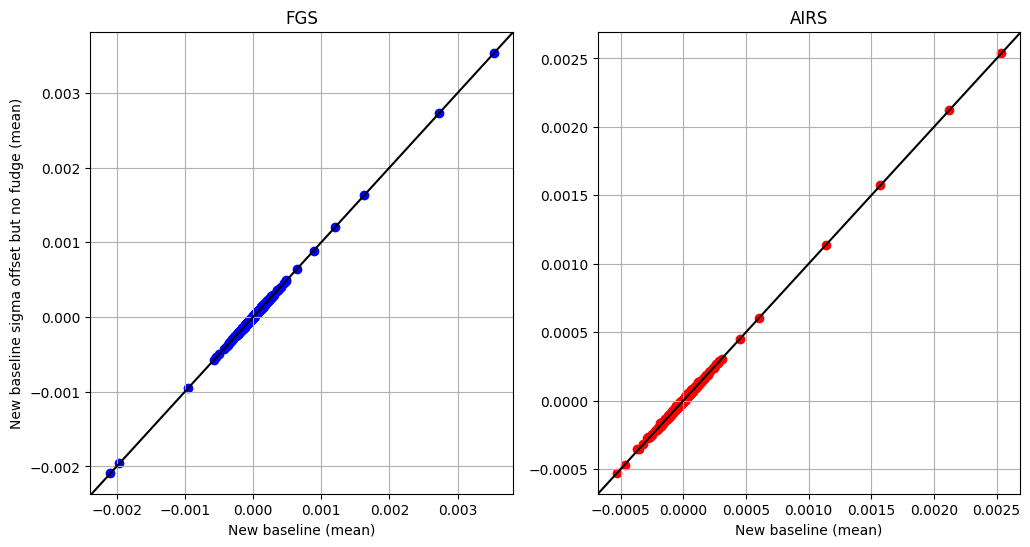

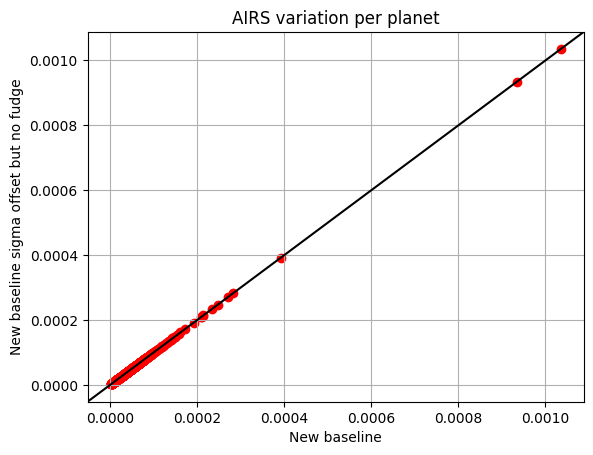

In [23]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        plt.scatter(x,y,color = col)

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:plt.axline((0,0),slope=1,color='black'))

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [ ]:
# import subprocess

# # Hibernate Windows
# subprocess.run(
#     ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
#     check=True
# )

In [ ]:
model._cached_result